In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime,timedelta

In [2]:
ticker = 'AAPL'  # Change this to any stock symbol
end_date = datetime.today().strftime('%Y-%m-%d')
fd = yf.download(ticker, start='2010-01-01', end=end_date)
df = fd[['Close']]  # Use only closing prices
print(fd)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2010-01-04    6.440331    6.455077    6.391279    6.422877  493729600
2010-01-05    6.451466    6.487879    6.417459    6.458086  601904800
2010-01-06    6.348846    6.477045    6.342226    6.451466  552160000
2010-01-07    6.337109    6.379843    6.291066    6.372319  477131200
2010-01-08    6.379239    6.379841    6.291367    6.328682  447610800
...                ...         ...         ...         ...        ...
2025-04-08  172.419998  190.339996  169.210007  186.699997  120859500
2025-04-09  198.850006  200.610001  171.889999  171.949997  184395900
2025-04-10  190.419998  194.779999  183.000000  189.070007  121880000
2025-04-11  198.149994  199.539993  186.059998  186.100006   87435900
2025-04-14  202.520004  212.940002  201.160004  211.440002  101203700

[3844 rows x 5 colu

In [3]:
df.isnull().sum()

Price  Ticker
Close  AAPL      0
dtype: int64

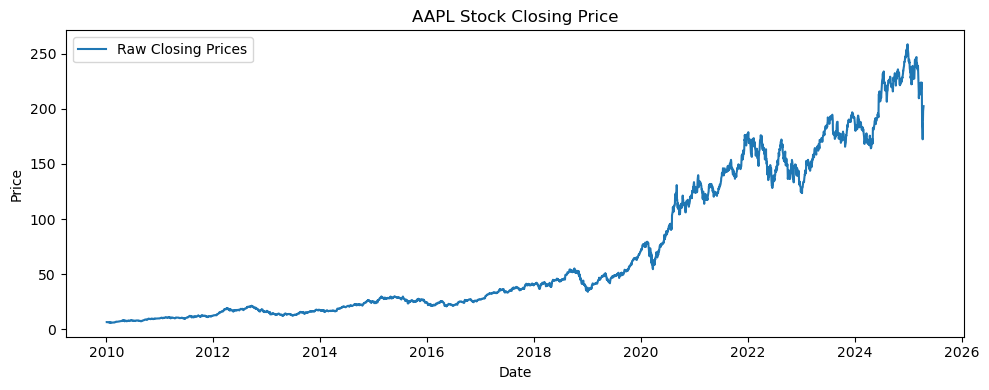

In [4]:
plt.figure(figsize=(10, 4))
plt.plot(df, label="Raw Closing Prices")
plt.title(f"{ticker} Stock Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [6]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


In [7]:
seq_length = 60  # Use past 60 days as input
X, y = create_sequences(scaled_data, seq_length)

In [8]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [9]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),  
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - loss: 0.0050 - mae: 0.0366 - val_loss: 0.0026 - val_mae: 0.0440
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 5.5992e-04 - mae: 0.0135 - val_loss: 0.0019 - val_mae: 0.0362
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 3.4752e-04 - mae: 0.0115 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 4/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 3.8495e-04 - mae: 0.0121 - val_loss: 6.5552e-04 - val_mae: 0.0198
Epoch 5/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 3.4772e-04 - mae: 0.0119 - val_loss: 6.2799e-04 - val_mae: 0.0195
Epoch 6/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 3.4991e-04 - mae: 0.0117 - val_loss: 6.2346e-04 - val_mae: 0.0194
Epoch 7/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 3.0981e-04 - mae: 0.0112 - val_loss: 0.0061 - val_mae: 0.0728
Epoch 8/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 4.7184e-04 - mae: 0.0139 - val_loss: 0.0022 - val_mae:

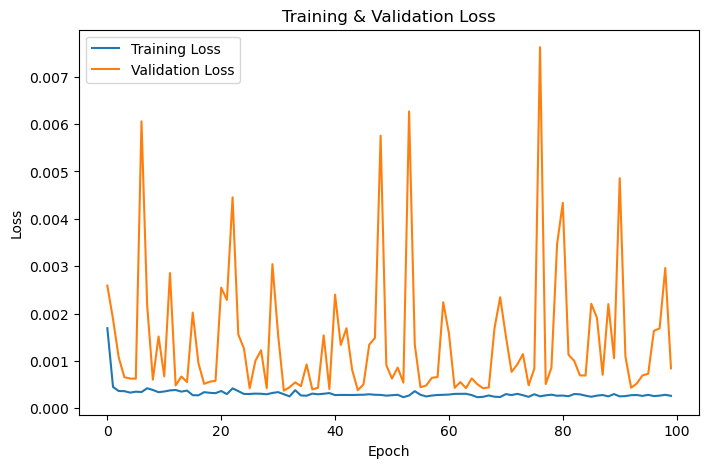

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

In [12]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


In [13]:
future_predictions = []
last_seq = X_test[-1]  # Last sequence from test data

for _ in range(7):
    next_pred = model.predict(last_seq.reshape(1, seq_length, 1))
    future_predictions.append(next_pred[0, 0])
    last_seq = np.roll(last_seq, -1)
    last_seq[-1] = next_pred  # Add the new prediction to the sequence

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


In [14]:
last_date = df.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, 8)]

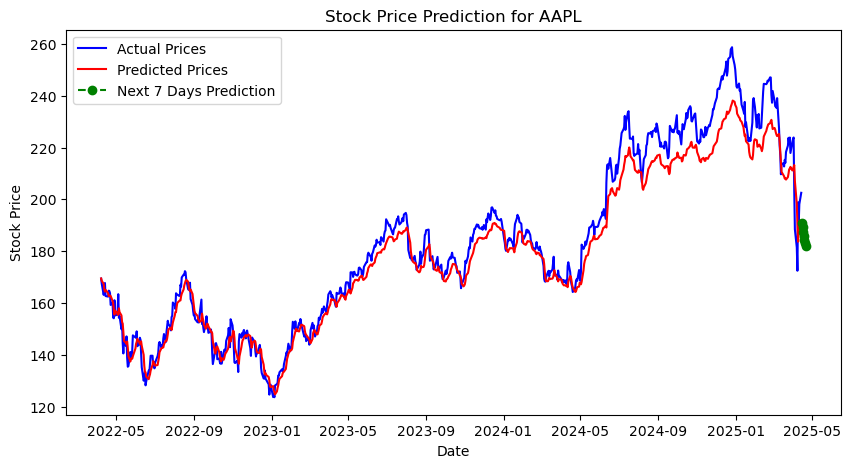

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual Prices", color='blue')
plt.plot(df.index[-len(y_test):], predictions, label="Predicted Prices", color='red')
plt.plot(future_dates, future_predictions, label="Next 7 Days Prediction", linestyle="dashed", marker='o', color='green')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title(f"Stock Price Prediction for {ticker}")
plt.show()

In [16]:
for date, price in zip(future_dates, future_predictions.flatten()):
    print(f"Predicted price on {date.date()}: ${price:.2f}")


Predicted price on 2025-04-15: $191.03
Predicted price on 2025-04-16: $189.44
Predicted price on 2025-04-17: $187.56
Predicted price on 2025-04-18: $185.88
Predicted price on 2025-04-19: $184.48
Predicted price on 2025-04-20: $183.25
Predicted price on 2025-04-21: $182.08


In [17]:
model.save('stock.h5')